In [1]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import config
import matplotlib.pyplot as plt

In [2]:
model = 'BiLSTM-proselflc-noisy-40.19-theta(0.7)-exp(12)'

In [3]:
df = pd.read_csv('/home/kriti/ambivalent/' + model + '.csv')

In [4]:
print(classification_report(df['ground-truth'], df['prediction']))

              precision    recall  f1-score   support

         ang       0.32      0.45      0.37       170
         exc       0.38      0.28      0.32       299
         fru       0.31      0.29      0.30       381
         hap       0.21      0.22      0.21       143
         neu       0.38      0.38      0.38       384
         sad       0.51      0.55      0.53       245

    accuracy                           0.36      1622
   macro avg       0.35      0.36      0.35      1622
weighted avg       0.36      0.36      0.36      1622



In [5]:
print(config.labels)

['ang', 'exc', 'fru', 'hap', 'neu', 'sad']


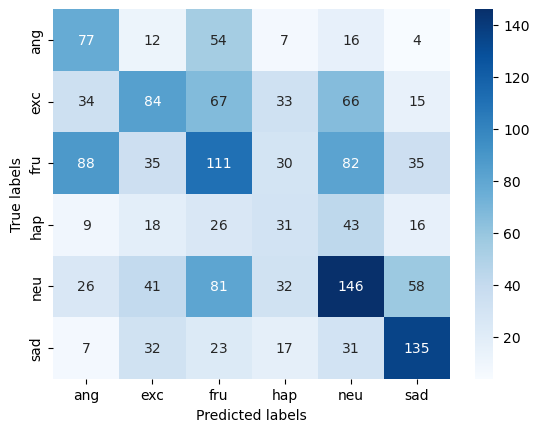

In [6]:
cm = confusion_matrix(df['ground-truth'], df['prediction'], labels=config.labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(config.labels)
ax.yaxis.set_ticklabels(config.labels)
plt.savefig('/home/kriti/ambivalent/images/'+ model + '-cm.png')

In [7]:
# create a separate vm, incompatible torch
import torch
from torch import nn, Tensor

def expected_calibration_error_multiclass(y_true, y_prob, num_bins=10):
    """
    Calculate the Expected Calibration Error (ECE) for a probabilistic multiclass classification model.

    Parameters:
        y_true (numpy array): True labels (ground truth) as integers (0 to num_classes-1).
        y_prob (numpy array): Predicted probabilities for each class (shape: [n_samples, num_classes]).
        num_bins (int): Number of bins to divide the probability range into (default is 10).

    Returns:
        float: Expected Calibration Error (ECE) value.
    """
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    # Calculate confidence bins
    bin_boundaries = np.linspace(0, 1, num_bins + 1)

    # Initialize variables to accumulate values for ECE calculation
    ece = 0.0
    bin_correct = np.zeros(num_bins)
    bin_total = np.zeros(num_bins)

    # Calculate predicted classes for each sample
    y_pred = np.argmax(y_prob, axis=1)

    # Calculate the confidence of the predictions (maximum probability)
    confidences = np.max(y_prob, axis=1)

    # Iterate over each prediction and calculate ECE
    for i in range(num_bins):
        # Find indices of predictions falling into the current bin
        bin_indices = np.logical_and(confidences >= bin_boundaries[i], confidences < bin_boundaries[i + 1])

        # Count total number of predictions in the bin for each class
        bin_total[i] = np.sum(bin_indices)

        # Calculate the accuracy for this bin for each class
        if bin_total[i] > 0:
            bin_accuracy = np.mean(y_pred[bin_indices] == y_true[bin_indices])
            bin_correct[i] = bin_accuracy * bin_total[i]
            ece += np.abs(bin_accuracy - np.mean(confidences[bin_indices])) * bin_total[i]

    # Normalize ECE by the total number of predictions
    ece /= np.sum(bin_total)

    return ece

class CrossEntropy(nn.Module):
    """
    The new implementation of cross entropy using two distributions.
    This can be a base class for other losses:
        1. label smoothing;
        2. bootsoft (self label correction), joint-soft,etc.
        3. proselflc
        ...

    Inputs: two tensors for predictions and target.
        1. predicted probability distributions of shape (N, C)
        2. target probability  distributions of shape (N, C)

    Outputs: scalar tensor, normalised by the number of examples.
    """

    def __init__(self) -> None:
        super().__init__()

    def forward(self, y_pred: Tensor, y_true: Tensor, cur_time: int) -> Tensor:
        """one_hot=True, 
        Inputs:
            pred_probs: predictions of shape (N, C).
            target_probs: targets of shape (N, C).

        Outputs:
            Loss: a scalar tensor, normalised by N.
        """
        epsilon = 1e-15  # Small constant to avoid log(0)
    
        # Ensure y_pred and y_true have the same shape
        assert y_pred.shape == y_true.shape, "Shapes of y_pred and y_true must be the same."
    
        # Clip the predicted probabilities to avoid log(0)
        y_pred = torch.clamp(y_pred, epsilon, 1.0 - epsilon)
        
        # Compute the Cross Entropy Loss
        loss = - torch.sum(y_true * torch.log(y_pred), dim=1)
        avg_loss = torch.mean(loss)
        
        return avg_loss

pred_conf = []
for x in df['pred-conf']:
    pred_conf.append([float(num) for num in x[1:-2].split()])

gt_conf = []
for x in df['gt-conf']:
    gt_conf.append([float(num) for num in x[1:-2].split()])

soft_gt_conf = []
for x in df['soft-gt-conf']:
    soft_gt_conf.append([float(num) for num in x[1:-2].split()])

tensor_pred_conf = torch.Tensor(np.array(pred_conf))
tensor_gt_conf = torch.Tensor(np.array(gt_conf))
tensor_soft_gt_conf = torch.Tensor(np.array(soft_gt_conf))

#print(pred_conf)
#print(gt_conf)
cce_loss = CrossEntropy()
print("hard", expected_calibration_error_multiclass(y_true=np.argmax(tensor_gt_conf.numpy(), -1), y_prob=tensor_pred_conf.numpy()))
print("soft", expected_calibration_error_multiclass(y_true=np.argmax(tensor_gt_conf.numpy(), -1), y_prob=tensor_pred_conf.numpy()))
print("cce loss", cce_loss(tensor_pred_conf, tensor_soft_gt_conf, None))

hard 0.3983888057024072
soft 0.3983888057024072
cce loss tensor(8.4348)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Generate some example predicted embeddings (replace with your actual data)
num_samples = 1000
embedding_dim = 128

model_checkpoint = torch.load(model_path)
model = model.load_state_dict(model_checkpoint['model'])
predicted_embeddings = model()

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(predicted_embeddings)

# Plot the t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], marker='o', color='b', s=10)
plt.title("t-SNE Embeddings from Model Predictions")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()

In [2]:
"""
Loss functions
"""
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import config

class ParamException(Exception):
    """
    Invalid parameter exception
    """

    def __init__(self, msg, fields=None):
        self.fields = fields
        self.msg = msg

    def __str__(self):
        return self.msg


def get_loss_func(loss_type, params=None):
    if loss_type == 'cce':
        return CrossEntropy()
    if loss_type == 'kl':
        return KLDiv()
    elif loss_type == 'proselflc':
        return ProSelfLC(params)
    else:
        print("Incorrect loss fn name!")

    
class KLDiv(nn.Module):
    """
        Compute the Kullback-Leibler (KL) Divergence Loss given predicted probabilities and target probabilities.
        
        Arguments:
        y_pred -- PyTorch tensor of shape (num_samples, num_classes) representing predicted probabilities.
        y_true -- PyTorch tensor of shape (num_samples, num_classes) representing target probabilities.
        
        Returns:
        loss -- scalar value representing the KL Divergence Loss averaged over the samples.
    """
    def __init__(self) -> None:
        super().__init__()

    def forward(self, y_pred: Tensor, y_true: Tensor, cur_time: int) -> Tensor:
        """one_hot=True, 
        Inputs:
            pred_probs: predictions of shape (N, C).
            target_probs: targets of shape (N, C).

        Outputs:
            Loss: a scalar tensor, normalised by N.
        """
        assert y_pred.shape == y_true.shape, "Shapes of y_pred and y_true must be the same."
    
        # Compute the KL Divergence Loss using the PyTorch function kl_div
        loss = F.kl_div(y_pred.log(), y_true, reduction='mean')
        
        return loss


class CrossEntropy(nn.Module):
    """
    The new implementation of cross entropy using two distributions.
    This can be a base class for other losses:
        1. label smoothing;
        2. bootsoft (self label correction), joint-soft,etc.
        3. proselflc
        ...

    Inputs: two tensors for predictions and target.
        1. predicted probability distributions of shape (N, C)
        2. target probability  distributions of shape (N, C)

    Outputs: scalar tensor, normalised by the number of examples.
    """

    def __init__(self) -> None:
        super().__init__()

    def forward(self, y_pred: Tensor, y_true: Tensor, cur_time: int) -> Tensor:
        """one_hot=True, 
        Inputs:
            pred_probs: predictions of shape (N, C).
            target_probs: targets of shape (N, C).

        Outputs:
            Loss: a scalar tensor, normalised by N.
        """
        epsilon = 1e-15  # Small constant to avoid log(0)
    
        # Ensure y_pred and y_true have the same shape
        assert y_pred.shape == y_true.shape, "Shapes of y_pred and y_true must be the same."
    
        # Clip the predicted probabilities to avoid log(0)
        y_pred = torch.clamp(y_pred, epsilon, 1.0 - epsilon)
        
        # Compute the Cross Entropy Loss
        loss = - torch.sum(y_true * torch.log(y_pred), dim=1)
        avg_loss = torch.mean(loss)
        
        return avg_loss, None
    


class ProSelfLC(CrossEntropy):
    """
    The implementation for progressive self label correction (CVPR 2021 paper).
    The target probability will be corrected by
    a predicted distributions, i.e., self knowledge.
        1. ProSelfLC is partially inspired by prior related work,
            e.g., Pesudo-labelling.
        2. ProSelfLC is partially theorectically bounded by
            early stopping regularisation.

    Inputs: two tensors for predictions and target.
        1. predicted probability distributions of shape (N, C)
        2. target probability  distributions of shape (N, C)
        3. current time (epoch/iteration counter).
        4. total time (total epochs/iterations)
        5. exp_base: the exponential base for adjusting epsilon
        6. counter: iteration or epoch counter versus total time.

    Outputs: scalar tensor, normalised by the number of examples.
    """

    def __init__(
        self,
        params: dict = None,
    ) -> None:
        super().__init__()
        self.total_epochs = params["total_epochs"]
        self.exp_base = params["exp_base"]
        self.counter = params["counter"]
        self.epsilon = None
        self.transit_time_ratio = params["transit_time_ratio"]

        if not (self.exp_base >= 0):
            error_msg = (
                "self.exp_base = "
                + str(self.exp_base)
                + ". "
                + "The exp_base has to be no less than zero. "
            )
            raise (ParamException(error_msg))

        if not (isinstance(self.total_epochs, int) and self.total_epochs > 0):
            error_msg = (
                "self.total_epochs = "
                + str(self.total_epochs)
                + ". "
                + "The total_epochs has to be a positive integer. "
            )
            raise (ParamException(error_msg))

        if self.counter not in ["iteration", "epoch"]:
            error_msg = (
                "self.counter = "
                + str(self.counter)
                + ". "
                + "The counter has to be iteration or epoch. "
                + "The training time is counted by eithor of them. "
            )
            raise (ParamException(error_msg))

        if "total_iterations" in params.keys():
            # only exist when counter == "iteration"
            self.total_iterations = params["total_iterations"]

    def update_epsilon_progressive_adaptive(self, pred_probs, cur_time):
        with torch.no_grad():
            # global trust/knowledge
            if self.counter == "epoch":
                time_ratio_minus_half = torch.tensor(
                    cur_time / self.total_epochs - self.transit_time_ratio
                )
            else:
                time_ratio_minus_half = torch.tensor(
                    cur_time / self.total_iterations - self.transit_time_ratio
                )
            #print("cur time", cur_time)
            #print("transit time ratio", self.transit_time_ratio)
            #print("time ratio minus half", time_ratio_minus_half)
            global_trust = 1 / (1 + torch.exp(-self.exp_base * time_ratio_minus_half))
            #print("global trust", global_trust)
            # example-level trust/knowledge
            class_num = pred_probs.shape[1]
            H_pred_probs = torch.sum(
                -(pred_probs + 1e-12) * torch.log(pred_probs + 1e-12), 1
            )
            H_uniform = -torch.log(torch.tensor(1.0 / class_num))
            #print("H_pred_probs", H_pred_probs)
            #print("H_uniform", H_uniform)
            example_trust = 1 - H_pred_probs / H_uniform
            #example_trust = torch.ones((H_pred_probs.shape))
            example_trust.to('cuda')
            #print("example trust", example_trust)
            # the trade-off
            self.epsilon = global_trust * example_trust
            # from shape [N] to shape [N, 1]
            self.epsilon = self.epsilon[:, None]
            self.epsilon = self.epsilon.to('cuda')
            #print("epsilon", self.epsilon)

    def forward(self, y_pred: Tensor, y_true: Tensor, cur_time: int) -> Tensor:
        """
        Inputs:
            1. predicted probability distributions of shape (N, C)
            2. target probability  distributions of shape (N, C)
            3. current time (epoch/iteration counter).

        Outputs:
            Loss: a scalar tensor, normalised by N.
        """
        #pred_probs = F.softmax(pred_probs, -1)
        if self.counter == "epoch":
            # cur_time indicate epoch
            if not (cur_time <= self.total_epochs and cur_time >= 0):
                error_msg = (
                    "The cur_time = "
                    + str(cur_time)
                    + ". The total_time = "
                    + str(self.total_epochs)
                    + ". The cur_time has to be no larger than total time "
                    + "and no less than zero."
                )
                raise (ParamException(error_msg))
        else:  # self.counter == "iteration":
            # cur_time indicate iteration
            if not (cur_time <= self.total_iterations and cur_time >= 0):
                error_msg = (
                    "The cur_time = "
                    + str(cur_time)
                    + ". The total_time = "
                    + str(self.total_iterations)
                    + ". The cur_time has to be no larger than total time "
                    + "and no less than zero."
                )
                raise (ParamException(error_msg))

        # update self.epsilon
        self.update_epsilon_progressive_adaptive(y_pred, cur_time)
        #print(pred_probs.get_device())
        #print(target_probs.get_device())
        #print(self.epsilon.get_device())
        new_target_probs = (1 - self.epsilon) * y_true + self.epsilon * y_pred
        # reuse CrossEntropy's forward computation
        #print("pred probs", pred_probs)
        #print("old target probs", target_probs)
        #print("new target probs", new_target_probs)     
        loss, _ = super().forward(y_pred, new_target_probs, cur_time)   
        return loss, new_target_probs

In [5]:
train_loss_params = {"weights": torch.Tensor([1, 1, 1, 1, 1, 1]), "total_epochs": 20, "total_iterations": 20, "exp_base": 12, "transit_time_ratio": 0.5 , "counter": "iteration"}
loss = ProSelfLC(train_loss_params)

In [10]:
pred_probs = torch.Tensor([[0.7, 0.3, 0, 0, 0, 0]]).to('cuda')
target_probs = torch.Tensor([[0.5, 0.5, 0, 0, 0, 0]]).to('cuda')
print(loss(pred_probs, target_probs, cur_time=10))

(tensor(0.7245, device='cuda:0'), tensor([[0.5659, 0.4341, 0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0'))


In [15]:
import torch

cur_time = 10
total_iterations = 20
transit_time_ratio = 0.5
exp_base = 12

pred_probs = torch.Tensor([[0.7, 0.3, 0, 0, 0, 0]]).to('cuda')
target_probs = torch.Tensor([[0.5, 0.5, 0, 0, 0, 0]]).to('cuda')

# Calculate time_ratio_minus_half
time_ratio_minus_half = torch.tensor(cur_time / total_iterations - transit_time_ratio)

# Calculate global_trust
global_trust = 1 / (1 + torch.exp(-exp_base * time_ratio_minus_half))

# Calculate example_trust
class_num = pred_probs.shape[1]
H_pred_probs = torch.sum(-(pred_probs + 1e-12) * torch.log(pred_probs + 1e-12), 1)
H_uniform = -torch.log(torch.tensor(1.0 / class_num))
example_trust = 1 - H_pred_probs / H_uniform

# Calculate epsilon
epsilon = global_trust * example_trust

# Calculate new_target_probs
new_target_probs = (1 - epsilon) * target_probs + epsilon * pred_probs

print("New Target Probabilities:")
print(new_target_probs)


New Target Probabilities:
tensor([[0.5659, 0.4341, 0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Generate some example predicted embeddings (replace with your actual data)
num_samples = 1000
embedding_dim = 128
predicted_embeddings = np.random.randn(num_samples, embedding_dim)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(predicted_embeddings)

# Plot the t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], marker='o', color='b', s=10)
plt.title("t-SNE Embeddings from Model Predictions")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()